In [8]:
import io
import re
import torch
import random 
import pickle
import librosa
import pathlib
import itertools
import scipy.fft
import torchaudio
import torchvision
import scipy as sp
import numpy as np
import glob as glob
from PIL import Image
import torch.nn as nn
import librosa.display
import torch.optim as optim
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from scipy.fftpack import fft, dct, idct
from scipy.io.wavfile import read, write

In [9]:
def sdct(signal, frame_length, frame_step, window="hamming"):
    """Compute Short-Time Discrete Cosine Transform of `signal`.
    Parameters
    ----------
    signal : Time-domain input signal of shape `(n_samples,)`.
    frame_length : Window length and DCT frame length in samples.
    frame_step : Number of samples between adjacent DCT columns.
    window : Window specification passed to ``librosa.filters.get_window``.
        Default: "hamming".  Window to use for DCT.
    Returns
    -------
    dct : Real-valued F-T domain DCT matrix of shape `(frame_length, n_frames)`
    """
    framed = librosa.util.frame(signal, frame_length, frame_step)
    if window is not None:
        window = librosa.filters.get_window(window, frame_length, fftbins=True).astype(
            signal.dtype
        )
        framed = framed * window[:, np.newaxis]
    return scipy.fft.dct(framed, norm="ortho", axis=-2)

def isdct(dct, *, frame_step, frame_length=None, window="hamming"):
    """Compute Inverse Short-Time Discrete Cosine Transform of `dct`.
    Parameters other than `dct` are keyword-only.
    Parameters
    ----------
    dct : DCT matrix from `sdct`.
    frame_step : Number of samples between adjacent DCT columns (should be the
        same value that was passed to `sdct`).
    frame_length : Ignored. Window length and DCT frame length in samples.
        Can be None (default) or same value as passed to `sdct`.
    window : Window specification passed to ``librosa.filters.get_window``.
        Default: "hamming".  Window to use for IDCT.
    Returns
    -------
    signal : Time-domain signal reconstructed from `dct` of shape `(n_samples,)`.
        Note that `n_samples` may be different from the original signal's length as passed to `sdct`.
    """
    frame_length2, n_frames = dct.shape
    assert frame_length in {None, frame_length2}
    signal = overlap_add(scipy.fft.idct(dct, norm="ortho", axis=-2), frame_step)
    if window is not None:
        window = librosa.filters.get_window(window, frame_length2, fftbins=True).astype(
            dct.dtype
        )
        window_frames = np.tile(window[:, np.newaxis], (1, n_frames))
        window_signal = overlap_add(window_frames, frame_step)
        signal = signal / window_signal
    return signal

def overlap_add(framed, frame_step):
    """Overlap-add ("deframe") a framed signal.
    Parameters
    ----------
    framed : array_like, frames of shape `(..., frame_length, n_frames)`.
    frame_step : Overlap to use when adding frames.
    Returns
    -------
    deframed : Overlap-add ("deframed") signal.
        np.ndarray of shape `(..., (n_frames - 1) * frame_step + frame_length)`.
    """
    *shape_rest, frame_length, n_frames = framed.shape
    deframed_size = (n_frames - 1) * frame_step + frame_length
    deframed = np.zeros((*shape_rest, deframed_size), dtype=framed.dtype)
    for i in range(n_frames):
        pos = i * frame_step
        deframed[..., pos : pos + frame_length] += framed[..., i]
    return deframed

In [85]:
class ImageProcessor():
    def __init__(self, image_path):
        self.image = Image.open(image_path).convert('RGB')
        
    def crop(self, proportion = 2 ** 6):
        nx, ny = self.image.size
        n = min(nx, ny)
        left = top = n / proportion
        right = bottom = (proportion - 1) * n / proportion
        self.image = self.image.crop((left, top, right, bottom))

    def scale(self, n = 256):
        self.image = self.image.resize((n, n), Image.ANTIALIAS)
        
    def normalize(self):
        self.image = np.array(self.image).astype('float') / 255.0

    def forward(self):
        self.crop()
        self.scale()
        self.normalize()
        return self.image

In [362]:
DATA_FOLDER = '../data/FSDnoisy18k.audio_train'
_limit = 2 ** 16 + 2 ** 11 - 1
s = glob.glob(f'{DATA_FOLDER}/*')[20]
sr, y = read(s)
sound, sr = torchaudio.load(s)
# Get the samples dimension
sound = sound[0]
# Create a temporary array
tmp = torch.zeros([_limit,]).normal_(mean = 0, std = 0.005)
# Cut the audio on limit
if sound.numel() < _limit:
    print('SMALLER')
    tmp[:sound.numel()] = sound[:]
else:
    i = random.randint(0, len(sound) - _limit)
    tmp[:] = sound[i:i + _limit]

print(len(sound), len(tmp))
sound_stct = sdct(tmp.numpy().astype(np.float32), frame_length=4096, frame_step=62)
im = torch.tensor(np.array(ImageProcessor('../data/sample_images/1.jpg').forward())).unsqueeze(0)
au = torch.tensor(sound_stct).unsqueeze(0).unsqueeze(0)
im = im.permute(0, 3, 1, 2).type(torch.FloatTensor)
print(au.shape, im.shape)

ipd.Audio(s)

707012 67583
torch.Size([1, 1, 4096, 1024]) torch.Size([1, 3, 256, 256])


In [483]:
def compare_images(s, r, epoch=None):
    s = s.permute(0,2,3,1).detach().numpy().squeeze(0).astype(np.float32)
    r = r.permute(0,2,3,1).detach().numpy().squeeze(0).astype(np.float32)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(s)
    ax[1].imshow(r)
    ax[0].set_title('Secret image')
    ax[1].set_title('Revealed image')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

def compare_spectral_info(cv, ct, epoch=None):
    cv = cv.detach().numpy().squeeze(0).squeeze(0).astype(np.float32)
    ct = ct.detach().numpy().squeeze(0).squeeze(0).astype(np.float32)
    
    fig, ax = plt.subplots(2,2, figsize=(25, 10))
    
    img1 = ax[0,0].imshow(np.log(np.abs(cv) + 1)[:4800,], origin = 'lower', aspect = 'auto', cmap=plt.cm.get_cmap("jet"))
    ax[0,0].set_title('Cover cosine log magnitude spectrum')
    
    img2 = ax[0,1].imshow(cv[:500,], origin = 'lower', aspect = 'auto', cmap=plt.cm.get_cmap("jet"))
    ax[0,1].set_title('Cover cosine spectrum x zoom')
    
    img3 = ax[1,0].imshow(np.log(np.abs(ct) + 1)[:4800,], origin = 'lower', aspect = 'auto', cmap=plt.cm.get_cmap("jet"))
    ax[1,0].set_title('Container cosine log magnitude spectrum')
    
    img4 = ax[1,1].imshow(ct[:500,], origin = 'lower', aspect = 'auto', cmap=plt.cm.get_cmap("jet"))
    ax[1,1].set_title('Container cosine spectrum x zoom')
    
    plt.colorbar(img1, ax=ax[0,0])
    plt.colorbar(img2, ax=ax[0,1])
    plt.colorbar(img3, ax=ax[1,0])
    plt.colorbar(img4, ax=ax[1,1])
    plt.show()

def viz2paper(s, r, cv, ct):
    s = s.permute(0,2,3,1).detach().numpy().squeeze(0).squeeze(2).astype(np.float32)
    r = r.permute(0,2,3,1).detach().numpy().squeeze(0).squeeze(2).astype(np.float32)
    cv = cv.detach().numpy().squeeze(0).squeeze(0).astype(np.float32)
    ct = ct.detach().numpy().squeeze(0).squeeze(0).astype(np.float32)
    

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax[0,0].imshow(s)
    ax[1,0].imshow(r)
    ax[0,0].set_title('Secret image')
    ax[1,0].set_title('Revealed image')
    ax[0,0].axis('off')
    ax[1,0].axis('off')
    
    img1 = ax[0,1].imshow(np.abs(cv) [:,], origin = 'lower', aspect = 'auto', cmap=plt.cm.get_cmap("jet"))
    ax[0,1].set_title('Cover STCT magnitude spectrum')
    img2 = ax[1,1].imshow(np.abs(ct)[:,], origin = 'lower', aspect = 'auto', cmap=plt.cm.get_cmap("jet"))
    ax[1,1].set_title('Container STCT magnitude spectrum')
    
    ax[0,1].set_xlabel('Time [n]')
    ax[0,1].set_ylabel('Frequency')
    ax[1,1].set_xlabel('Time [n]')
    ax[1,1].set_ylabel('Frequency')
    
    plt.colorbar(img1, ax=ax[0,1])
    plt.colorbar(img2, ax=ax[1,1])
    plt.show()

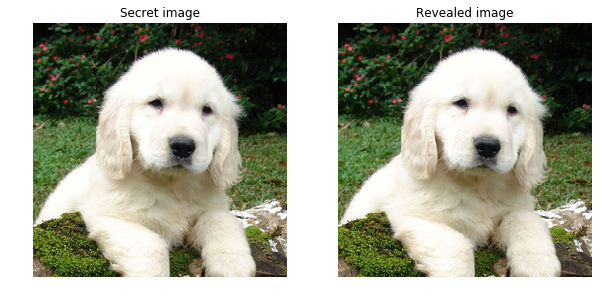

In [88]:
compare_images(im, im)

In [89]:
imn = im 
imn.min(), imn.max(), imn.shape

(tensor(0.), tensor(1.), torch.Size([1, 3, 256, 256]))

In [92]:
class SecretPrepNet(nn.Module):
	def __init__(self):
		super().__init__()
		self.features3x3 = nn.Sequential(
			nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(4, 1), padding=(1, 1)),
			nn.LeakyReLU(0.8),
			nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
			nn.LeakyReLU(0.8),
			nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
		)

		self.features5x5 = nn.Sequential(
			nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(8, 2), padding=(1, 2)),
			nn.LeakyReLU(0.8),
			nn.Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
		)

		self.deep_features3x3 = nn.Sequential(
			nn.Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
		)

		self.deep_features5x5 = nn.Sequential(
			nn.Conv2d(32, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
		)

	def forward(self, x):
		features3x3 = self.features3x3(x)
		features5x5 = self.features5x5(x)

		x = torch.cat((features3x3, features5x5), 1)

		deep_features3x3 = self.deep_features3x3(x)
		deep_features5x5 = self.deep_features5x5(x)

		x = torch.cat((deep_features3x3, deep_features5x5), 1)
		return x


class HidingNet(nn.Module):
	def __init__(self):
		super().__init__()
		self.features3x3 = nn.Sequential(
			nn.Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
			nn.LeakyReLU(0.8),
			nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
			nn.LeakyReLU(0.8),
			nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
		)

		self.features5x5 = nn.Sequential(
			nn.Conv2d(24, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
			nn.LeakyReLU(0.8),
			nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
		)

		self.deep_features3x3 = nn.Sequential(
			nn.Upsample(scale_factor=(4, 2), mode='bilinear'),
			nn.Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
			nn.LeakyReLU(0.8),
			nn.Upsample(scale_factor=(4, 2), mode='bilinear'),
			nn.Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
		)

		self.deep_features5x5 = nn.Sequential(
			nn.Upsample(scale_factor=(4, 2), mode='bilinear'),
			nn.Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
			nn.LeakyReLU(0.8),
			nn.Upsample(scale_factor=(4, 2), mode='bilinear'),
			nn.Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
		)

		self.funnel = nn.Sequential(
			nn.Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
		)

	def forward(self, x):
		features3x3 = self.features3x3(x)
		features5x5 = self.features5x5(x)

		x = torch.cat((features3x3, features5x5), 1)

		deep_features3x3 = self.deep_features3x3(x)
		deep_features5x5 = self.deep_features5x5(x)

		x = torch.cat((deep_features3x3, deep_features5x5), 1)
		x = self.funnel(x)

		return x


class RevealNet(nn.Module):
	def __init__(self):
		super().__init__()
		self.features3x3 = nn.Sequential(
			nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(4, 1), padding=(1, 1)),
			nn.LeakyReLU(0.8),
			nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
			nn.LeakyReLU(0.8),
			nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
		)

		self.features5x5 = nn.Sequential(
			nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(8, 2), padding=(1, 2)),
			nn.LeakyReLU(0.8),
			nn.Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
		)

		self.deep_features3x3 = nn.Sequential(
			nn.Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
		)

		self.deep_features5x5 = nn.Sequential(
			nn.Conv2d(32, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
		)

		self.funnel = nn.Sequential(
			nn.Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
		)

	def forward(self, x):
		features3x3 = self.features3x3(x)
		features5x5 = self.features5x5(x)

		x = torch.cat((features3x3, features5x5), 1)

		deep_features3x3 = self.deep_features3x3(x)
		deep_features5x5 = self.deep_features5x5(x)

		x = torch.cat((deep_features3x3, deep_features5x5), 1)
		x = self.funnel(x)
		return x


class StegoNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.sPN = SecretPrepNet()
        self.cPN = CoverPrepNet()
        self.HN = HidingNet()
        self.RN = RevealNet()

    def forward(self, secret, cover):
        print('Secret Preprocessing Network working ...')
        secret_features = self.sPN(cover)
        print('Cover Preprocessing Network working ...')
        cover_features = self.cPN(cover)
        mixed_features = secret_features + cover_features
        print('Hiding Network working ...')
        hidden_signal = self.HN(mixed_features)
        container = cover + hidden_signal
        print('Reveal Network working ...')
        revealed = self.RN(container)

        return container, revealed

In [94]:
au = torch.rand(1, 1, 4096, 1024)
im = torch.rand(1, 3, 256, 256)
au.shape, im.shape

(torch.Size([1, 1, 4096, 1024]), torch.Size([1, 3, 256, 256]))

In [435]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.8, inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.8, inplace=True),
        )

    def forward(self, x):
        # print(8*'='+'DOUBLE CONV')
        # print(8*'-'+f'Starting shape ({x.shape[1]}x{x.shape[2]}x{x.shape[3]})')
        x = self.conv1(x)
        #x = self.conv2(x)
        # print(8*'-'+f'Final shape ({x.shape[1]}x{x.shape[2]}x{x.shape[3]})')
        return x

In [436]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels, downsample_factor=8, mid_channels=None):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
        self.conv = DoubleConv(in_channels, out_channels, mid_channels)
        self.down = nn.MaxPool2d(downsample_factor)

    def forward(self, x):
        # print(5*'='+'DOWN')
        # print(5*'-'+f'Original shape ({x.shape[1]}x{x.shape[2]}x{x.shape[3]})')
        x = self.conv(x)
        x = self.down(x)
        # print(5*'-'+f'Downsampled shape ({x.shape[1]}x{x.shape[2]}x{x.shape[3]})')
        return x

In [510]:
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None, image_alone = False):
        super().__init__()
        self.image_alone = image_alone
        if not mid_channels:
            mid_channels = out_channels
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels , mid_channels, kernel_size=3, stride=4, output_padding=0),
            nn.LeakyReLU(0.8, inplace=True),
            nn.ConvTranspose2d(mid_channels , out_channels, kernel_size=3, stride=2, output_padding=1),
            nn.LeakyReLU(0.8, inplace=True),
        )
        self.conv = DoubleConv(out_channels * 2 if self.image_alone else out_channels * 3, out_channels, mid_channels)

    def forward(self, mix, im_opposite, au_opposite = None):
        # print(5*'='+'UP')
        # print(5*'-'+f'Original shape ({mix.shape[1]}x{mix.shape[2]}x{mix.shape[3]})')
        mix = self.up(mix)
        # print(5*'-'+f'Upsampled shape ({mix.shape[1]}x{mix.shape[2]}x{mix.shape[3]})')
        x = torch.cat((mix, im_opposite), dim=1) if self.image_alone else torch.cat((au_opposite, mix, im_opposite), dim=1)
        # print(5*'-'+f'Concat shape ({x.shape[1]}x{x.shape[2]}x{x.shape[3]})')
        return self.conv(x)

In [511]:
class PrepHidingNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.au_encoder_layers = nn.ModuleList([
            Down(1, 64),
            Down(64, 64 * 2)
        ])
        
        self.im_encoder_layers = nn.ModuleList([
            Down(1, 64),
            Down(64, 64 * 2)
        ])
        
        self.decoder_layers = nn.ModuleList([
            Up(64 * 2, 64),
            Up(64, 1)
        ])

    def forward(self, im, au):
        
        im_enc = [nn.Upsample(scale_factor=(16, 4), mode='bilinear', align_corners=True)(im)]
        au_enc = [au]
        
        for enc_layer_idx, enc_layer in enumerate(self.au_encoder_layers):
            # print(f'au Encoder layer #{enc_layer_idx + 1}')
            au_enc.append(enc_layer(au_enc[-1]))
        
        for enc_layer_idx, enc_layer in enumerate(self.im_encoder_layers):
            # print(f'im Encoder layer #{enc_layer_idx + 1}')
            im_enc.append(enc_layer(im_enc[-1]))

        mix_dec = [au_enc.pop(-1) + im_enc.pop(-1)]
        
        for dec_layer_idx, dec_layer in enumerate(self.decoder_layers):
            # print(f'Decoder layer #{dec_layer_idx + 1}')
            mix_dec.append(dec_layer(mix_dec[-1], im_enc[-1-dec_layer_idx], au_enc[-1-dec_layer_idx]))

        return mix_dec[-1]

In [512]:
class RevealNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.au_encoder_layers = nn.ModuleList([
            Down(1, 64),
            Down(64, 64 * 2)
        ])
        
        self.im_encoder_layers = nn.ModuleList([
            Down(1, 64),
            Down(64, 64 * 2)
        ])
        
        self.decoder_layers = nn.ModuleList([
            Up(64 * 2, 64, image_alone = True),
            Up(64, 1, image_alone = True)
        ])

    def forward(self, ct):
        
        im_enc = [F.interpolate(ct, size=(256, 256))]
        
        for enc_layer_idx, enc_layer in enumerate(self.im_encoder_layers):
            # print(f'im Encoder layer #{enc_layer_idx + 1}')
            im_enc.append(enc_layer(im_enc[-1]))
        
        im_dec = [im_enc.pop(-1)]
        
        for dec_layer_idx, dec_layer in enumerate(self.decoder_layers):
            # print(f'Decoder layer #{dec_layer_idx + 1}')
            im_dec.append(dec_layer(im_dec[-1], im_enc[-1-dec_layer_idx]))

        return im_dec[-1]

In [447]:
u = PHNet()
decr = u.forward(im, au)

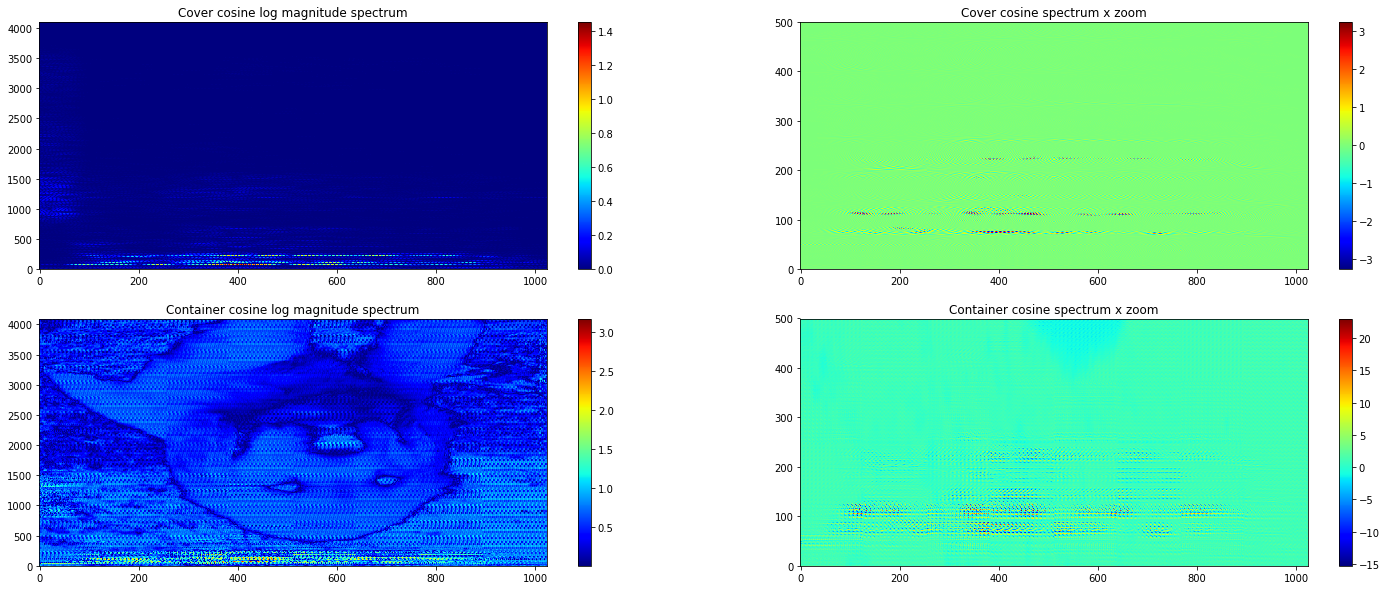

In [449]:
compare_spectral_info(au, decr + au)

In [460]:
r = RNet()
imr = r.forward(decr)

im Encoder layer #1
im Encoder layer #2


In [499]:
class StegoUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.PHN = PrepHidingNet()
        self.RN = RevealNet()

    def forward(self, secret, cover):
        print('Process + Hiding Network working ...')
        hidden_signal = self.PHN(secret, cover)
        
        container = cover + hidden_signal
        
        print('Reveal Network working ...')
        revealed = self.RN(container)

        return container, revealed

In [514]:
model = StegoUNet()
ct, rv = model.forward(torch.sum(im, axis=1).unsqueeze(0), au)

Process + Hiding Network working ...
Reveal Network working ...


In [513]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
model = StegoUNet()
get_n_params(model)

1520609

In [481]:
ct.shape, rv.shape

(torch.Size([1, 1, 4096, 1024]), torch.Size([1, 1, 256, 256]))

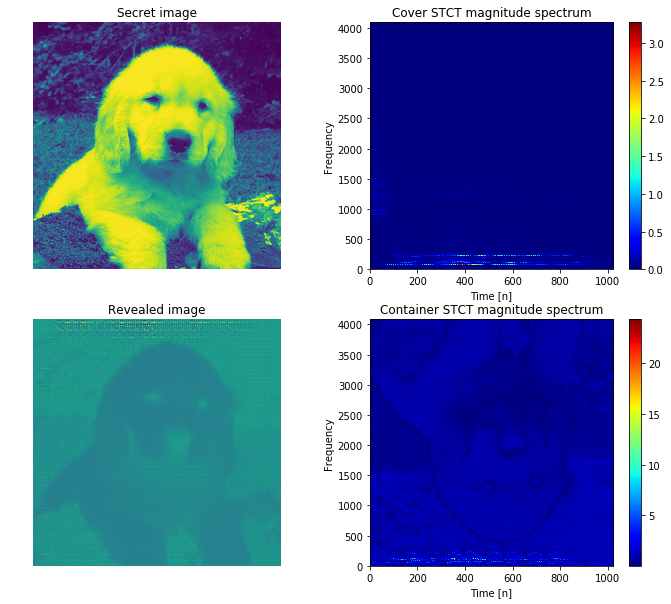

In [484]:
viz2paper(torch.sum(im, axis=1).unsqueeze(0), rv, au, ct)

(256, 256)
(256, 256)


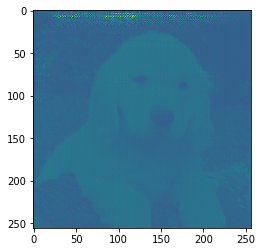

In [462]:
d = imr.permute(0,2,3,1).squeeze(0).detach().numpy().squeeze(2)
print(d.shape)
print(d.shape)
plt.imshow(d)